In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import textman as tx
import seaborn as sns; sns.set()
import re
%matplotlib inline

# Import and Preprocess 

In [2]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/sk5be/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sk5be/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/sk5be/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to /home/sk5be/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sk5be/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Revised import function

We pause to look at the revised form of our text import function. The parsing function has been replaced with NLTK, which has improved the results of POS tagging. However, this has required some added string manipulation to produce better tokens.

In [7]:
OHCO = ['book_num','chap_num', 'para_num', 'sent_num', 'token_num']
BOOKS = OHCO[:1]
CHAPS = OHCO[:2]
PARAS = OHCO[:3]
SENTS = OHCO[:4]

In [4]:
"""
NOTE: NLTK tokenization messes up whitespace and 
handles non-alpha characters differently.
"""

def text_to_tokens(
                   src_file,
                   body_start=0, 
                   body_end=-1, 
                   chap_pat=r'^\s*Chapter.*$', 
                   para_pat=r'\n\n+', 
                   sent_pat=r'([.;?!"“”]+)', 
                   token_pat=r'([\W_]+)'):

    # Text to lines
    lines = open(src_file, 'r', encoding='utf-8').readlines()
    lines = lines[body_start - 1 : body_end + 1]
    df = pd.DataFrame({'line_str':lines})
    df.index.name = 'line_id'
    del(lines)
    
    # FIX CHARACTERS TO IMPROVE TOKENIZATION
    df.line_str = df.line_str.str.replace('—', ' — ')
    df.line_str = df.line_str.str.replace('-', ' - ')

    # Lines to Chapters
    mask = df.line_str.str.match(chap_pat)
    df.loc[mask, 'chap_id'] = df.apply(lambda x: x.name, 1)
    df.chap_id = df.chap_id.ffill().astype('int')
    chap_ids = df.chap_id.unique().tolist()
    df['chap_num'] = df.chap_id.apply(lambda x: chap_ids.index(x))
    chaps = df.groupby('chap_num')\
        .apply(lambda x: ''.join(x.line_str))\
        .to_frame()\
        .rename(columns={0:'chap_str'})
    del(df)

    # Chapters to Paragraphs
    paras = chaps.chap_str.str.split(para_pat, expand=True)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'para_str'})
    paras.index.names = PARAS
    paras.para_str = paras.para_str.str.strip()
    paras.para_str = paras.para_str.str.replace(r'\n', ' ')
    paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
    paras = paras[~paras.para_str.str.match(r'^\s*$')]
    del(chaps)

    # Paragraphs to Sentences
#     sents = paras.para_str.str.split(sent_pat, expand=True)\
    sents = paras.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    sents.index.names = SENTS
    del(paras)

    # Sentences to Tokens
#     tokens = sents.sent_str.str.split(token_pat, expand=True)\
    tokens = sents.sent_str\
        .apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    tokens.index.names = OHCO
    del(sents)
    
    tokens['pos'] = tokens.pos_tuple.apply(lambda x: x[1])
    tokens['token_str'] = tokens.pos_tuple.apply(lambda x: x[0])
    tokens = tokens.drop('pos_tuple', 1)

    # Tag punctuation and numbers
    tokens['punc'] = tokens.token_str.str.match(r'^[\W_]*$').astype('int')
    tokens['num'] = tokens.token_str.str.match(r'^.*\d.*$').astype('int')
    
    # Extract vocab with minimal normalization
    WORDS = (tokens.punc == 0) & (tokens.num == 0)
    tokens.loc[WORDS, 'term_str'] = tokens.token_str.str.lower()\
        .str.replace(r'["_*.]', '')
    
    vocab = tokens[tokens.punc == 0].term_str.value_counts().to_frame()\
        .reset_index()\
        .rename(columns={'index':'term_str', 'term_str':'n'})
    vocab = vocab.sort_values('term_str').reset_index(drop=True)
    vocab.index.name = 'term_id'
    
    # Get priors for V
    vocab['p'] = vocab.n / vocab.n.sum()
    
    # Add stems
    stemmer = nltk.stem.porter.PorterStemmer()
    vocab['port_stem'] = vocab.term_str.apply(lambda x: stemmer.stem(x))
    
    # Define stopwords
    sw = pd.DataFrame({'x':1}, index=nltk.corpus.stopwords.words('english'))
    vocab['stop'] = vocab.term_str.map(sw.x).fillna(0).astype('int')
    del(sw)
            
    # Add term_ids to tokens 
    tokens['term_id'] = tokens['term_str'].map(vocab.reset_index()\
        .set_index('term_str').term_id).fillna(-1).astype('int')

    return tokens, vocab

def get_docs(tokens, div_names, doc_str = 'term_id', sep='', flatten=False, 
             index_only=False):
    
    if not index_only:
        docs = tokens.groupby(div_names)[doc_str]\
          .apply(lambda x: x.str.cat(sep=sep))
        docs.columns = ['doc_content']
    else:
        docs = tokens.groupby(div_names)[doc_str].apply(lambda x: x.tolist())

    if flatten:
        docs = docs.reset_index().drop(div_names, 1)
    
    return docs

def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

In [12]:
max_words = 10000000
corpus_db = "/sfs/qumulo/qhome/sk5be/DS5559/HarryPotter.db"
sql = """
SELECT * FROM token 
WHERE term_id IN (
    SELECT term_id FROM vocab 
    WHERE stop = 0 
    AND term_str NOT IN ('said')
)
AND (pos NOT LIKE 'NNP%')
""".format(max_words)
sql_vocab = """
SELECT * FROM vocab """.format(max_words)
#
with sqlite3.connect(corpus_db) as db:
    tokens = pd.read_sql(sql,db)
with sqlite3.connect(corpus_db) as db:
    vocab = pd.read_sql(sql_vocab,db)
V = vocab.copy()
K = tokens.copy()
#
G = K.groupby(OHCO[:4])\
  .apply(lambda x: np.random.choice(['train', 'test'], p=[.8, .2]))\
  .to_frame().rename(columns={0:'group'})
K = pd.merge(K.reset_index(), G.reset_index(), on=OHCO[:4], how='left')
K = K.set_index(OHCO, drop=True)

In [6]:
# lemmatizer = nltk.stem.WordNetLemmatizer()
# # ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
# nouns = (K.punc == 0) & K.pos.str.match(r'^N')
# verbs = (K.punc == 0) & K.pos.str.match(r'^V')
# K.loc[nouns, 'lemma'] = K[nouns].apply(lambda x: lemmatizer.lemmatize(x.term_str, pos='n'), 1)
# K.loc[verbs, 'lemma'] = K[verbs].apply(lambda x: lemmatizer.lemmatize(x.term_str, pos='v'), 1)

In [13]:
K.head()

index pos  token_str  punc  \
book_num chap_num para_num sent_num token_num                               
0        0        0        0        0              0  NN    CHAPTER     0   
                  2        0        6              1  NN     number     0   
                                    7              2  CD       four     0   
                                    13             3  JJ      proud     0   
                                    19             4  RB  perfectly     0   

                                               num   term_str  term_id  group  
book_num chap_num para_num sent_num token_num                                  
0        0        0        0        0            0    chapter     4164  train  
                  2        0        6            0     number    14134   test  
                                    7            0       four     8850   test  
                                    13           0      proud    16076   test  
                                    19           0  perfectly    15107   test

In [7]:
K.head()

pos  token_str  punc  num   term_str  \
chap_num para_num sent_num token_num                                         
0        0        0        0          NNP  ETYMOLOGY     0    0  etymology   
                           1            .          .     1    0        NaN   
         1        0        0            (          (     1    0        NaN   
                           1          VBN   Supplied     0    0   supplied   
                           2           IN         by     0    0         by   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             5005  
                           1               -1  
         1        0        0               -1  
                           1            14441  
                           2             1987

In [14]:
V.head(3)

,term_id,term_str,n,p,port_stem,stop
0,0,''just,1,8.912283e-07,''just,0
1,1,''professor,1,8.912283e-07,''professor,0
2,2,''was,1,8.912283e-07,''wa,0


In [8]:
V.head()

,term_str,n,p,port_stem,stop
term_id,,,,,
0,a,4724,0.021629,a,1
1,aback,2,0.000009,aback,0
2,abaft,2,0.000009,abaft,0
3,abandon,3,0.000014,abandon,0
4,abandoned,7,0.000032,abandon,0


## Test to see if 'and' is annotated properly

In [15]:
K[K.term_str=='and'].pos

Series([], Name: pos, dtype: object)

In [16]:
K[(K.term_str=='and') & K.pos.isna()]

,,,,,index,pos,token_str,punc,num,term_str,term_id,group
book_num,chap_num,para_num,sent_num,token_num,,,,,,,,


## Create word mask

Let's filter out stopwords -- another hyperparameter. 

In [17]:
WORDS = (K.punc == 0) & (K.num == 0) & K.term_id.isin(V[V.stop==0].index)

## Extrct BOW from tokens

To extract a bag-of-words model from our tokens table, we apply a simple `groupby()` operation. Note that we can drop in our hyperparameters easily -- CHAPS and 'term_id' and be replaced. We can easily write a function to simplify this process and make it more configurable. 


In [18]:
BOW = K[WORDS].groupby(CHAPS+['term_id'])['term_id'].count()
BOW.head()

book_num  chap_num  term_id
0         0         218        17
                    598         7
                    620         2
                    840        13
                    874        46
Name: term_id, dtype: int64

## Convert BOW to DTM

In [19]:
DTM = BOW.unstack().fillna(0)

In [20]:
DTM.head()

term_id            0      1      2      3      4      5      6      7      \
book_num chap_num                                                           
0        0           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
         1           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
         2           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
         3           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
         4           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

term_id            8      9      ...    23701  23703  23704  23705  23706  \
book_num chap_num                ...                                        
0        0           0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   
         1           0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   
         2           0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   
         3           0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   
         4           0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   

term_id            23707  23712  23713  23714  23715  
book_num chap_num                                     
0        0           0.0    0.0    0.0    0.0    0.0  
         1           0.0    0.0    0.0    0.0    0.0  
         2           0.0    0.0    0.0    0.0    0.0  
         3           0.0    0.0    0.0    0.0    0.0  
         4           0.0    0.0    0.0    0.0    0.0  

[5 rows x 21797 columns]

# Compute Term Frequencies and Weights

## Compute TF

In [21]:
alpha = .000001 # We introduce an arbitrary smoothing value
alpha_sum = alpha * V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [22]:
TF.head()

term_id                   0             1             2             3      \
book_num chap_num                                                           
0        0         5.162559e-10  5.162559e-10  5.162559e-10  5.162559e-10   
         1         6.920302e-10  6.920302e-10  6.920302e-10  6.920302e-10   
         2         6.060519e-10  6.060519e-10  6.060519e-10  6.060519e-10   
         3         6.369331e-10  6.369331e-10  6.369331e-10  6.369331e-10   
         4         3.431681e-10  3.431681e-10  3.431681e-10  3.431681e-10   

term_id                   4             5             6             7      \
book_num chap_num                                                           
0        0         5.162559e-10  5.162559e-10  5.162559e-10  5.162559e-10   
         1         6.920302e-10  6.920302e-10  6.920302e-10  6.920302e-10   
         2         6.060519e-10  6.060519e-10  6.060519e-10  6.060519e-10   
         3         6.369331e-10  6.369331e-10  6.369331e-10  6.369331e-10   
         4         3.431681e-10  3.431681e-10  3.431681e-10  3.431681e-10   

term_id                   8             9          ...              23701  \
book_num chap_num                                  ...                      
0        0         5.162559e-10  5.162559e-10      ...       5.162559e-10   
         1         6.920302e-10  6.920302e-10      ...       6.920302e-10   
         2         6.060519e-10  6.060519e-10      ...       6.060519e-10   
         3         6.369331e-10  6.369331e-10      ...       6.369331e-10   
         4         3.431681e-10  3.431681e-10      ...       3.431681e-10   

term_id                   23703         23704         23705         23706  \
book_num chap_num                                                           
0        0         5.162559e-10  5.162559e-10  5.162559e-10  5.162559e-10   
         1         6.920302e-10  6.920302e-10  6.920302e-10  6.920302e-10   
         2         6.060519e-10  6.060519e-10  6.060519e-10  6.060519e-10   
         3         6.369331e-10  6.369331e-10  6.369331e-10  6.369331e-10   
         4         3.431681e-10  3.431681e-10  3.431681e-10  3.431681e-10   

term_id                   23707         23712         23713         23714  \
book_num chap_num                                                           
0        0         5.162559e-10  5.162559e-10  5.162559e-10  5.162559e-10   
         1         6.920302e-10  6.920302e-10  6.920302e-10  6.920302e-10   
         2         6.060519e-10  6.060519e-10  6.060519e-10  6.060519e-10   
         3         6.369331e-10  6.369331e-10  6.369331e-10  6.369331e-10   
         4         3.431681e-10  3.431681e-10  3.431681e-10  3.431681e-10   

term_id                   23715  
book_num chap_num                
0        0         5.162559e-10  
         1         6.920302e-10  
         2         6.060519e-10  
         3         6.369331e-10  
         4         3.431681e-10  

[5 rows x 21797 columns]

## Compute TFIDF

In [23]:
N_docs = DTM.shape[0]
V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / V[V.stop==0]['df'])

In [24]:
TFIDF.head()

0             1             2             3      \
book_num chap_num                                                           
0        0         3.942453e-09  3.942453e-09  3.942453e-09  1.409241e-09   
         1         5.284775e-09  5.284775e-09  5.284775e-09  1.889058e-09   
         2         4.628191e-09  4.628191e-09  4.628191e-09  1.654360e-09   
         3         4.864019e-09  4.864019e-09  4.864019e-09  1.738658e-09   
         4         2.620646e-09  2.620646e-09  2.620646e-09  9.367577e-10   

                          4             5             6             7      \
book_num chap_num                                                           
0        0         3.942453e-09  3.942453e-09  3.942453e-09  3.942453e-09   
         1         5.284775e-09  5.284775e-09  5.284775e-09  5.284775e-09   
         2         4.628191e-09  4.628191e-09  4.628191e-09  4.628191e-09   
         3         4.864019e-09  4.864019e-09  4.864019e-09  4.864019e-09   
         4         2.620646e-09  2.620646e-09  2.620646e-09  2.620646e-09   

                          8             9          ...              23706  \
book_num chap_num                                  ...                      
0        0         3.942453e-09  3.942453e-09      ...       3.942453e-09   
         1         5.284775e-09  5.284775e-09      ...       5.284775e-09   
         2         4.628191e-09  4.628191e-09      ...       4.628191e-09   
         3         4.864019e-09  4.864019e-09      ...       4.864019e-09   
         4         2.620646e-09  2.620646e-09      ...       2.620646e-09   

                          23707  23708  23709  23710  23711         23712  \
book_num chap_num                                                           
0        0         3.942453e-09    NaN    NaN    NaN    NaN  3.942453e-09   
         1         5.284775e-09    NaN    NaN    NaN    NaN  5.284775e-09   
         2         4.628191e-09    NaN    NaN    NaN    NaN  4.628191e-09   
         3         4.864019e-09    NaN    NaN    NaN    NaN  4.864019e-09   
         4         2.620646e-09    NaN    NaN    NaN    NaN  2.620646e-09   

                          23713         23714         23715  
book_num chap_num                                            
0        0         3.942453e-09  3.942453e-09  3.942453e-09  
         1         5.284775e-09  5.284775e-09  5.284775e-09  
         2         4.628191e-09  4.628191e-09  4.628191e-09  
         3         4.864019e-09  4.864019e-09  4.864019e-09  
         4         2.620646e-09  2.620646e-09  2.620646e-09  

[5 rows x 23510 columns]

## Compute TFTH (Experiment)

In [25]:
THM = -(TF * np.log2(TF))
TFTH = TF.apply(lambda x: x * THM.sum(), 1)

In [26]:
TFTH.head()

term_id                   0             1             2             3      \
book_num chap_num                                                           
0        0         1.875428e-12  2.382375e-12  3.225946e-12  1.046747e-10   
         1         2.513971e-12  3.193523e-12  4.324313e-12  1.403142e-10   
         2         2.201634e-12  2.796758e-12  3.787057e-12  1.228815e-10   
         3         2.313818e-12  2.939265e-12  3.980026e-12  1.291429e-10   
         4         1.246643e-12  1.583623e-12  2.144366e-12  6.957986e-11   

term_id                   4             5             6             7      \
book_num chap_num                                                           
0        0         3.248827e-12  2.823522e-12  1.759269e-12  1.855698e-12   
         1         4.354984e-12  3.784872e-12  2.358262e-12  2.487524e-12   
         2         3.813918e-12  3.314637e-12  2.065270e-12  2.178472e-12   
         3         4.008255e-12  3.483533e-12  2.170505e-12  2.289475e-12   
         4         2.159576e-12  1.876865e-12  1.169429e-12  1.233528e-12   

term_id                   8             9          ...              23701  \
book_num chap_num                                  ...                      
0        0         1.728149e-12  2.280083e-12      ...       3.201809e-12   
         1         2.316548e-12  3.056403e-12      ...       4.291958e-12   
         2         2.028738e-12  2.676674e-12      ...       3.758722e-12   
         3         2.132112e-12  2.813063e-12      ...       3.950246e-12   
         4         1.148744e-12  1.515628e-12      ...       2.128322e-12   

term_id                   23703         23704         23705         23706  \
book_num chap_num                                                           
0        0         2.639410e-12  3.006284e-12  3.653784e-12  3.050225e-12   
         1         3.538073e-12  4.029860e-12  4.897820e-12  4.088762e-12   
         2         3.098501e-12  3.529188e-12  4.289312e-12  3.580771e-12   
         3         3.256384e-12  3.709016e-12  4.507872e-12  3.763228e-12   
         4         1.754481e-12  1.998352e-12  2.428761e-12  2.027560e-12   

term_id                   23707         23712         23713         23714  \
book_num chap_num                                                           
0        0         2.364653e-12  2.737276e-12  2.412548e-12  3.006284e-12   
         1         3.169767e-12  3.669261e-12  3.233970e-12  4.029860e-12   
         2         2.775953e-12  3.213389e-12  2.832179e-12  3.529188e-12   
         3         2.917401e-12  3.377126e-12  2.976492e-12  3.709016e-12   
         4         1.571843e-12  1.819535e-12  1.603680e-12  1.998352e-12   

term_id                   23715  
book_num chap_num                
0        0         1.920013e-12  
         1         2.573737e-12  
         2         2.253974e-12  
         3         2.368825e-12  
         4         1.276280e-12  

[5 rows x 21797 columns]

## Add stats to V

In [27]:
V['tf_sum'] = TF.sum()
V['tf_mean'] = TF.mean()
V['tf_max'] = TF.max()
V['tfidf_sum'] = TFIDF.sum()
V['tfidf_mean'] = TFIDF.mean()
V['tfidf_max'] = TFIDF.max()
V['tfth_sum'] = TFTH.sum()
V['tfth_mean'] = TFTH.mean()
V['tfth_max'] = TFTH.max()
V['th_sum'] = THM.sum()
V['th_mean'] = THM.mean()
V['th_max'] = THM.max()

## Discussion

* Why do we add summary statistics to the vocabulary table?

# Find Significant Words

In [28]:
TOPS = pd.DataFrame(index=range(10))
for m in ['tf','tfidf','tfth', 'th']:
    for n in ['mean','max']:
        key = '{}_{}'.format(m,n)
        TOPS[key] = V.sort_values(key, ascending=False).term_str.head(10).tolist()

In [29]:
TOPS

,tf_mean,tf_max,tfidf_mean,tfidf_max,tfth_mean,tfth_max,th_mean,th_max
0,'s,'s,'s,sidecar,'s,'s,'s,'s
1,n't,n't,n't,expecto,n't,n't,n't,n't
2,back,wand,'i,troll,back,wand,back,wand
3,looked,yeh,'you,diadem,looked,back,looked,yeh
4,know,ter,yeh,ter,know,looked,know,ter
5,around,sir,ter,xenophilius,around,voice,around,sir
6,got,voice,'what,boggart,got,know,got,voice
7,see,car,'ve,yeh,see,eyes,see,car
8,think,father,sir,patronum,looking,around,looking,father
9,looking,water,'well,car,think,got,think,water


# Compare Chapters

## Create Docs table

In [31]:
def get_docs(tokens, div_names, doc_str = 'term_id', sep='', flatten=False, 
             index_only=False):
    
    if not index_only:
        docs = tokens.groupby(div_names)[doc_str]\
          .apply(lambda x: x.str.cat(sep=sep))
        docs.columns = ['doc_content']
    else:
        docs = tokens.groupby(div_names)[doc_str].apply(lambda x: x.tolist())

    if flatten:
        docs = docs.reset_index().drop(div_names, 1)
    
    return docs

In [32]:
D = get_docs(K, CHAPS, 'term_str', sep=" ")\
    .to_frame().rename(columns={'term_str':'doc_str'})

In [33]:
D.head()

doc_str
book_num chap_num                                                   
0        0         chapter number four proud perfectly normal tha...
         1         chapter nearly ten years passed since woken fi...
         2         chapter escape brazilian boa constrictor earne...
         3         chapter four knocked jerked awake 's cannon st...
         4         chapter five woke early next morning although ...

In [34]:
D['term_count'] = DTM.sum(1).astype('int').to_frame().rename(columns={0:'term_count'})
D['tf'] = D.term_count / D.term_count.sum()

In [35]:
D.head()

doc_str  \
book_num chap_num                                                      
0        0         chapter number four proud perfectly normal tha...   
         1         chapter nearly ten years passed since woken fi...   
         2         chapter escape brazilian boa constrictor earne...   
         3         chapter four knocked jerked awake 's cannon st...   
         4         chapter five woke early next morning although ...   

                   term_count        tf  
book_num chap_num                        
0        0               1937  0.004325  
         1               1445  0.003227  
         2               1650  0.003684  
         3               1570  0.003506  
         4               2914  0.006507

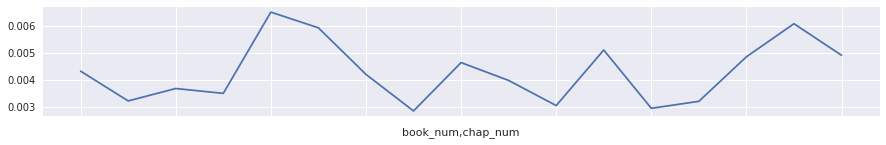

In [57]:
D.query('book_num == "0"').tf.plot(figsize=(15,2))

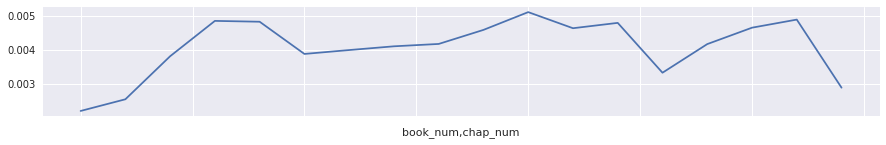

In [58]:
D.query('book_num == "1"').tf.plot(figsize=(15,2))

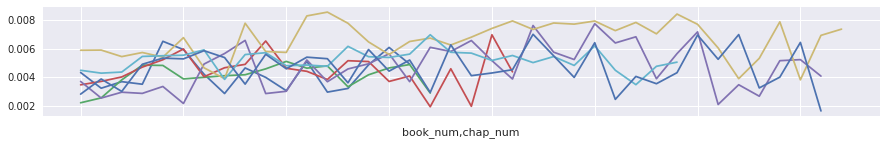

In [56]:
D.query('book_num == "2"').tf.plot(figsize=(15,2))
D.query('book_num == "3"').tf.plot(figsize=(15,2))
D.query('book_num == "4"').tf.plot(figsize=(15,2))
D.query('book_num == "5"').tf.plot(figsize=(15,2))
D.query('book_num == "6"').tf.plot(figsize=(15,2))

## Get all doc pairs

In [42]:
chap_ids = D.index.tolist()
pairs = [(i,j) for i in chap_ids for j in chap_ids if j > i]

In [60]:
P = pd.DataFrame(pairs).reset_index(drop=True).set_index([0,1])
P.index.names = ['doc_x','doc_y']

In [61]:
P.head()

Empty DataFrame
Columns: []
Index: [((0, 0), (0, 1)), ((0, 0), (0, 2)), ((0, 0), (0, 3)), ((0, 0), (0, 4)), ((0, 0), (0, 5))]

## Compute Euclidean distance

In [63]:
def euclidean(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = (D1 - D2)**2
    y = x.sum() 
    z = np.sqrt(y)
    return z

In [64]:
P['euclidean'] = 0
P['euclidean'] = P.apply(euclidean, 1)

In [65]:
P['euclidean_sim'] = 1 / (P.euclidean + 1)

In [66]:
PME = P.euclidean.unstack().fillna(0)

In [67]:
PME.head()

doc_y,"(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(0, 6)","(0, 7)","(0, 8)","(0, 9)","(0, 10)",...,"(6, 27)","(6, 28)","(6, 29)","(6, 30)","(6, 31)","(6, 32)","(6, 33)","(6, 34)","(6, 35)","(6, 36)"
doc_x,,,,,,,,,,,,,,,,,,,,,
"(0, 0)",0.105239,0.108582,0.117203,0.096112,0.093277,0.098555,0.105509,0.090675,0.108339,0.109940,...,0.098832,0.101708,0.094703,0.104854,0.098948,0.093155,0.098861,0.103785,0.093564,0.127403
"(0, 1)",0.000000,0.111763,0.125726,0.106432,0.103772,0.108480,0.114728,0.101584,0.117904,0.118986,...,0.111594,0.111559,0.106114,0.115302,0.107130,0.106081,0.108085,0.114914,0.104324,0.137050
"(0, 2)",0.000000,0.000000,0.123825,0.106290,0.103675,0.108731,0.114795,0.101009,0.117009,0.118645,...,0.111771,0.111291,0.105890,0.114798,0.109134,0.105116,0.109310,0.114875,0.104833,0.137340
"(0, 3)",0.000000,0.000000,0.000000,0.095983,0.111709,0.117256,0.121800,0.110772,0.126022,0.123299,...,0.119639,0.120307,0.114854,0.121844,0.117183,0.113338,0.117311,0.122332,0.112515,0.143975
"(0, 4)",0.000000,0.000000,0.000000,0.000000,0.086165,0.094830,0.100004,0.087467,0.105494,0.104794,...,0.098299,0.097984,0.092428,0.101787,0.095721,0.091892,0.096689,0.102196,0.090484,0.126875


## Compute Cosine similarity

In [69]:
def cosine(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = D1 * D2
    y = x.sum()
    
#     a = np.sqrt(D1.sum()**2)     # <-- misplaced exponent!
#     b = np.sqrt(D2.sum()**2)     # <-- misplaced exponent!
#     c = np.sqrt(a) * np.sqrt(b)  # <-- extra square roots!

    a = np.sqrt((D1**2).sum())
    b = np.sqrt((D2**2).sum())
    c = a * b
    
    z = y / c
    return z

In [70]:
from numpy.linalg import norm
def cosine_np(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    return np.dot(D1, D2)/(norm(D1)*norm(D2))

In [71]:
from scipy import spatial
def cosine_scipy(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    return (1 - spatial.distance.cosine(D1, D2))

In [72]:
from sklearn.metrics.pairwise import cosine_similarity
def cosine_sklearn(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    return cosine_similarity([TFIDF.loc[0]], [TFIDF.loc[1]])[0][0]

In [73]:
# %%timeit -- 11.8 s ± 958 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
P['cosine'] = P.apply(cosine, 1)

In [74]:
# %%timeit -- 7.23 s ± 877 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
P['cosine_scipy'] = P.apply(cosine_scipy, 1)

In [76]:
# %%timeit -- 4.48 s ± 480 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
P['cosine_np'] = P.apply(cosine_np, 1)

In [77]:
P.head()

euclidean  euclidean_sim    cosine  cosine_scipy  cosine_np
doc_x  doc_y                                                              
(0, 0) (0, 1)   0.105239       0.904782  0.159048           NaN        NaN
       (0, 2)   0.108582       0.902053  0.099302           NaN        NaN
       (0, 3)   0.117203       0.895092  0.084704           NaN        NaN
       (0, 4)   0.096112       0.912315  0.112229           NaN        NaN
       (0, 5)   0.093277       0.914681  0.104097           NaN        NaN

In [81]:
PMC = P.cosine.unstack().fillna(0)

In [82]:
PMC.head()

doc_y,"(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(0, 6)","(0, 7)","(0, 8)","(0, 9)","(0, 10)",...,"(6, 27)","(6, 28)","(6, 29)","(6, 30)","(6, 31)","(6, 32)","(6, 33)","(6, 34)","(6, 35)","(6, 36)"
doc_x,,,,,,,,,,,,,,,,,,,,,
"(0, 0)",0.159048,0.099302,0.084704,0.112229,0.104097,0.067947,0.078325,0.088439,0.065172,0.053842,...,0.121074,0.047660,0.084244,0.051911,0.057678,0.092444,0.060908,0.061458,0.068474,0.080403
"(0, 1)",0.000000,0.182823,0.079923,0.104798,0.100704,0.070318,0.079045,0.085915,0.058437,0.055043,...,0.066435,0.049076,0.064427,0.037592,0.091664,0.045839,0.076230,0.035735,0.065591,0.050363
"(0, 2)",0.000000,0.000000,0.104396,0.102489,0.097265,0.060957,0.073789,0.091337,0.068649,0.056422,...,0.058810,0.048957,0.063265,0.041560,0.051435,0.058565,0.049648,0.031833,0.050273,0.043095
"(0, 3)",0.000000,0.000000,0.000000,0.381502,0.099337,0.051633,0.080479,0.066111,0.042903,0.096134,...,0.057123,0.029723,0.049420,0.051532,0.050764,0.059637,0.049770,0.036246,0.062733,0.039495
"(0, 4)",0.000000,0.000000,0.000000,0.000000,0.192446,0.092104,0.136169,0.099662,0.076339,0.105637,...,0.088436,0.072176,0.078848,0.065299,0.072040,0.065827,0.054845,0.047340,0.077794,0.059832


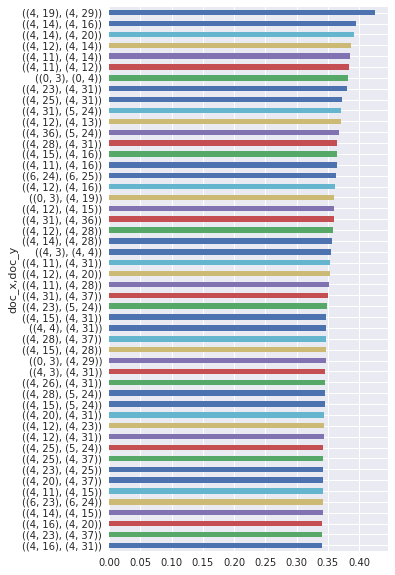

In [83]:
P.cosine.sort_values(ascending=True).tail(50).plot(kind='barh', figsize=(5,10))

In [84]:
P.cosine.reset_index().to_csv('HP-chapter-pairs.csv', index=False)

## Compare Euclidean and Cosine metrics

In [85]:
def len_diff(row):
    return abs(D.loc[row.name[0]].term_count - D.loc[row.name[1]].term_count)

In [86]:
P['len_diff'] = P.apply(len_diff, axis=1)

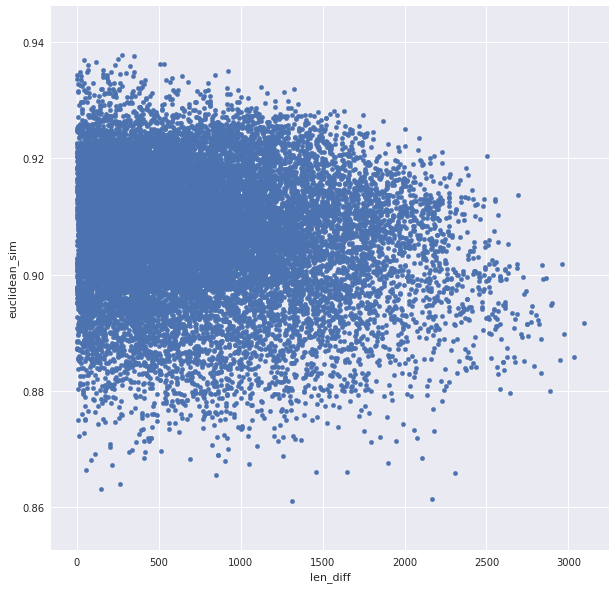

In [87]:
P.plot(kind='scatter', x='len_diff', y='euclidean_sim', figsize=(10,10))

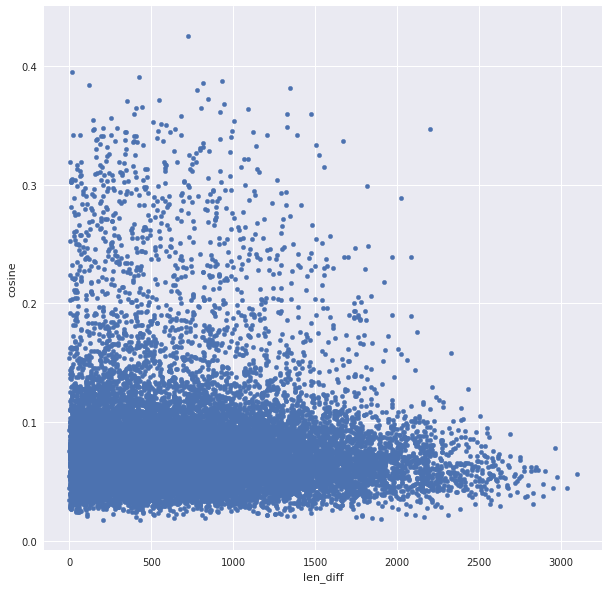

In [88]:
P.plot(kind='scatter', x='len_diff', y='cosine', figsize=(10,10))

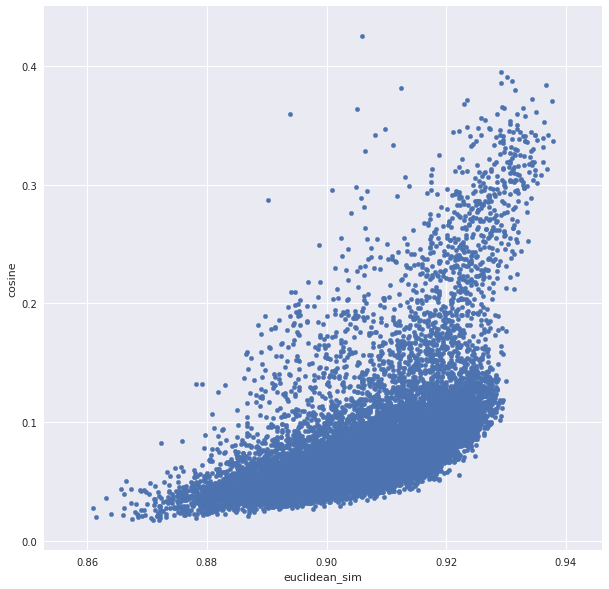

In [89]:
P.plot(kind='scatter', x='euclidean_sim', y='cosine', figsize=(10,10))

In [96]:
P.sort_values(by= ('euclidean'), ascending=False).head()

euclidean  euclidean_sim    cosine  cosine_scipy  cosine_np  \
doc_x   doc_y                                                                  
(2, 19) (6, 3)    0.161383       0.861043  0.027980           NaN        NaN   
        (4, 19)   0.160824       0.861457  0.020328           NaN        NaN   
        (6, 36)   0.158553       0.863145  0.036087           NaN        NaN   
(1, 1)  (2, 19)   0.157372       0.864027  0.023038           NaN        NaN   
(4, 19) (6, 3)    0.155238       0.865622  0.043459           NaN        NaN   

                 len_diff  
doc_x   doc_y              
(2, 19) (6, 3)       1316  
        (4, 19)      2165  
        (6, 36)       146  
(1, 1)  (2, 19)       263  
(4, 19) (6, 3)        849

In [98]:
P[P.euclidean > .1].head()

euclidean  euclidean_sim    cosine  cosine_scipy  cosine_np  \
doc_x  doc_y                                                                 
(0, 0) (0, 1)   0.105239       0.904782  0.159048           NaN        NaN   
       (0, 2)   0.108582       0.902053  0.099302           NaN        NaN   
       (0, 3)   0.117203       0.895092  0.084704           NaN        NaN   
       (0, 7)   0.105509       0.904560  0.078325           NaN        NaN   
       (0, 9)   0.108339       0.902251  0.065172           NaN        NaN   

               len_diff  
doc_x  doc_y             
(0, 0) (0, 1)       492  
       (0, 2)       287  
       (0, 3)       367  
       (0, 7)       658  
       (0, 9)       153

## See most similar chapters

In [103]:
P.cosine.sort_values(ascending=False).head()

doc_x    doc_y  
(4, 19)  (4, 29)    0.425237
(4, 14)  (4, 16)    0.395182
         (4, 20)    0.390984
(4, 12)  (4, 14)    0.387585
(4, 11)  (4, 14)    0.385470
Name: cosine, dtype: float64

In [102]:
D.head()

doc_str  \
book_num chap_num                                                      
0        0         chapter number four proud perfectly normal tha...   
         1         chapter nearly ten years passed since woken fi...   
         2         chapter escape brazilian boa constrictor earne...   
         3         chapter four knocked jerked awake 's cannon st...   
         4         chapter five woke early next morning although ...   

                   term_count        tf  
book_num chap_num                        
0        0               1937  0.004325  
         1               1445  0.003227  
         2               1650  0.003684  
         3               1570  0.003506  
         4               2914  0.006507

In [109]:
D.loc[(4, 19)]

doc_str       chapter 's sprinted boys dormitories fetch 's ...
term_count                                                 3044
tf                                                   0.00679718
Name: (4, 19), dtype: object

In [110]:
D.loc[(4, 29)]

doc_str       grawp story 's flight freedom retold often nex...
term_count                                                 3767
tf                                                   0.00841162
Name: (4, 29), dtype: object

# Compare Significant Words 

We look at distributions of words over chapters. Note, we are not comparing word vectors per se -- we are looking at sequences of words, which has not been discussed in the literature. 

In [113]:
def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

In [111]:
import matplotlib.pyplot as plt

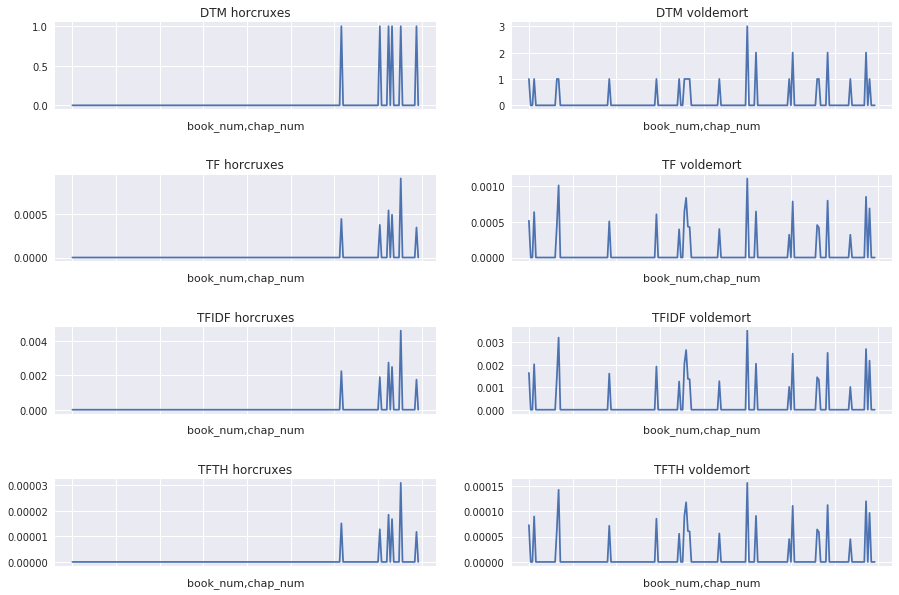

In [119]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('horcruxes voldemort'.split()):
    W = get_term_id(V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w))
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)